# TP 3 - Tópicos de Minería de Datos
### Juan Ignacio Farizano

--------------------------------------------------------------------------------

In [1]:
# imports iniciales
library(MASS)
library(e1071)

--------------------------------------------------------------------------------
## Ejercicio 1

Defino esta función que voy a usar para comparar soluciones de clustering o
contra las clases originales

In [2]:
compare.clusters <- function(clusters1, clusters2) {
  cont.table <- table(clusters1, clusters2)
  class.match <- matchClasses(as.matrix(cont.table),method="exact")
  print(cont.table[,class.match])
}

### Apartado a

#### Clustering divisivo

In [3]:
# importo los datos y separo las columnas con mediciones
data(crabs)
x.crabs <- crabs[,4:8]

Como tengo dos clasificaciones posibles, por especie o por sexo, ploteo los datos dos veces, usando los colores para distinguir. Prefiero plotear dos veces de esta forma porque me resulta más comprensible que usando color y forma en un mismo gráfico para separar.

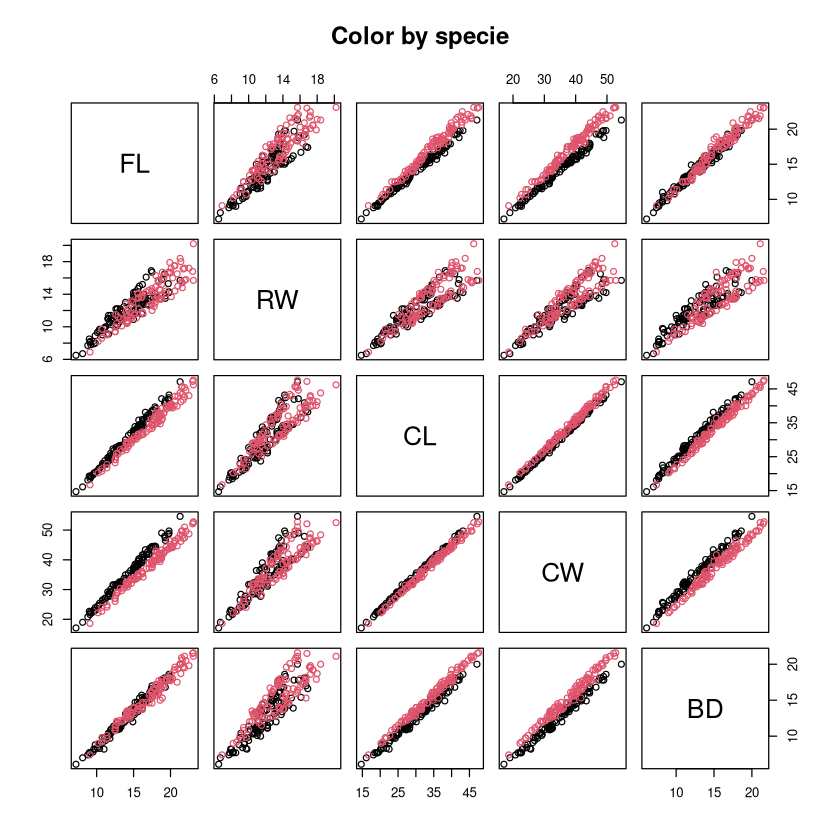

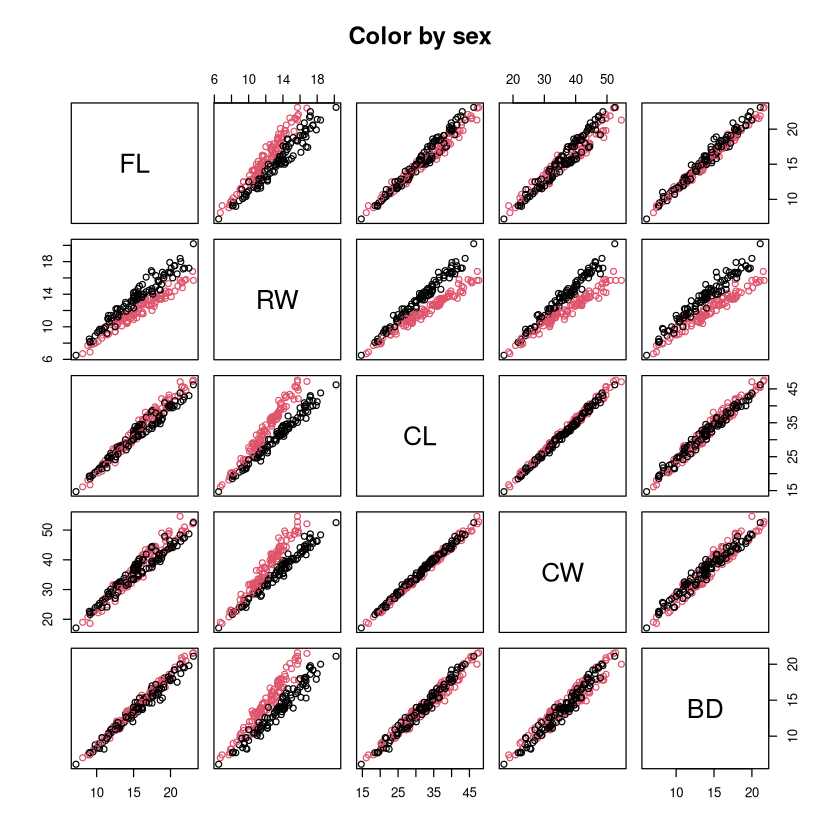

In [4]:
plot(x.crabs,col=as.numeric(crabs$sp), main="Color by specie")
plot(x.crabs,col=as.numeric(crabs$sex), main="Color by sex")

Viendo los gráficos, se puede notar que agarrando de a 2 variables no es posible separar los datos ya que están los dos grupos (en ambas clasificaciones) muy mezclados entre sí. Es probable que sea necesario usar PCA para separarlos mejor.

In [5]:
cc <- kmeans(x.crabs, cent=2)
cat("\n-- Species --\n")
compare.clusters(crabs$sp,cc$cluster)
cat("\n-- Sex --\n")
compare.clusters(crabs$sex,cc$cluster)


-- Species --
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 57.5 %
         clusters2
clusters1  1  2
        B 54 46
        O 39 61

-- Sex --
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 50.5 %
         clusters2
clusters1  2  1
        F 54 46
        M 53 47


Como esperaba, la clusterización no fue buena y no se pudieron separar las clases

In [6]:
x.crabs.log <- log(x.crabs)
cc <- kmeans(x.crabs.log, cent=2)
cat("\n-- Species --\n")
compare.clusters(crabs$sp,cc$cluster)
cat("\n-- Sex --\n")
compare.clusters(crabs$sex,cc$cluster)


-- Species --
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 60.5 %
         clusters2
clusters1  2  1
        B 48 52
        O 27 73

-- Sex --
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 51.5 %
         clusters2
clusters1  1  2
        F 64 36
        M 61 39


Sólamente aplicando logaritmo a los datos se sigue teniendo el mismo problema ya que no modifica cómo están distribuidos los puntos

In [7]:
x.crabs.log.scale <- as.data.frame(scale(x.crabs.log))
x.crabs.log.scale.pca <- as.data.frame(prcomp(x.crabs.log.scale)$x)
cc <- kmeans(x.crabs.log.scale.pca, cent=2)
cat("\n-- Species --\n")
compare.clusters(crabs$sp,cc$cluster)
cat("\n-- Sex --\n")
compare.clusters(crabs$sex,cc$cluster)


-- Species --
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 60.5 %
         clusters2
clusters1  1  2
        B 48 52
        O 27 73

-- Sex --
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 51.5 %
         clusters2
clusters1  2  1
        F 64 36
        M 61 39


Para hacer un poco más corta la notebook dejé fuera un poco el testeo de haber aplicado scale, clusterizar y después haber aplicado pca, clusterizar o haber aplicado solo pca sin scale.

Estas combinaciones no mejoraron el resultado notablemente, se seguía teniendo números similares a los anteriores.

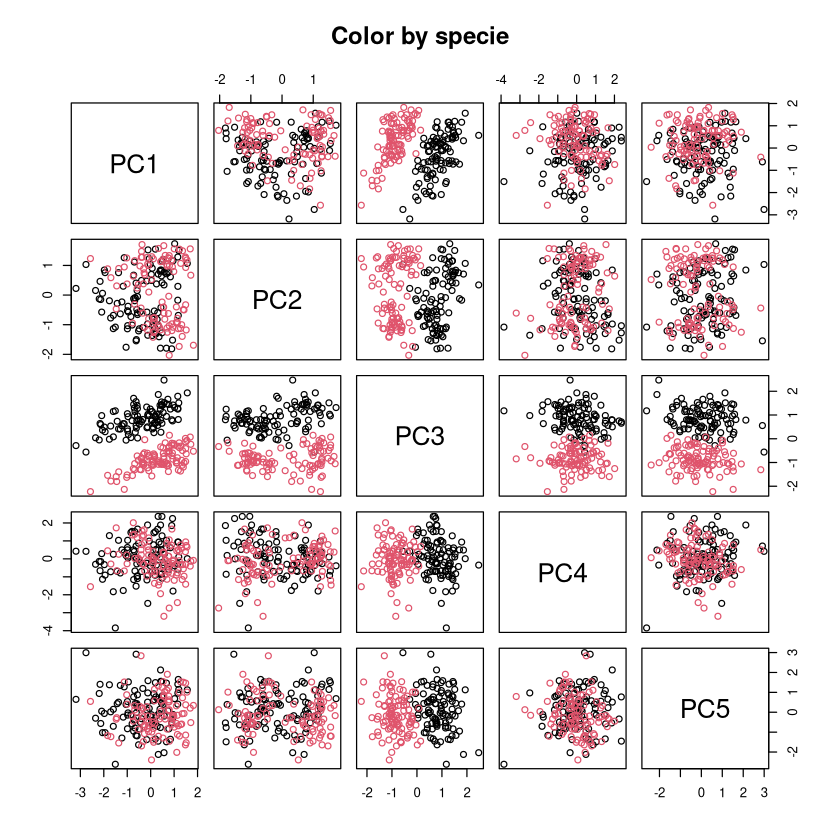

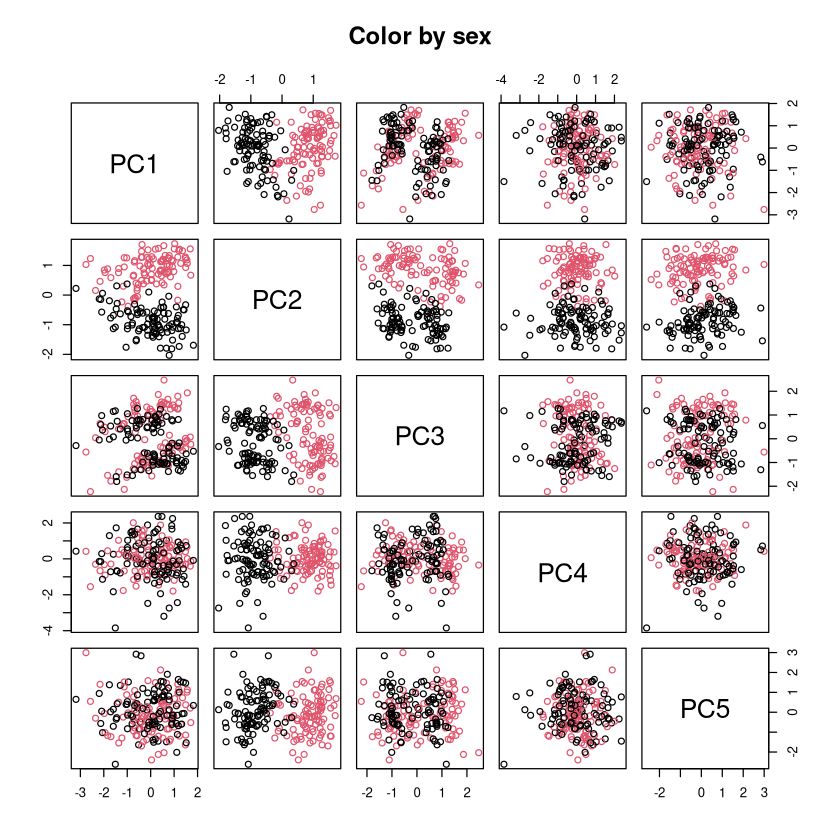

In [8]:
x.crabs.log.pca <- as.data.frame(prcomp(x.crabs.log)$x)
x.crabs.log.pca.scale <- as.data.frame(scale(x.crabs.log.pca))

plot(x.crabs.log.pca.scale,col=as.numeric(crabs$sp), main="Color by specie")
plot(x.crabs.log.pca.scale,col=as.numeric(crabs$sex), main="Color by sex")

La línea de tiempo de la resolución de este TP no se corresponde linealmente a lo escrito. 

Luego de haber aplicado PCA y después scale podemos ver cómo se produce una mayor separación entre los grupos para ambas clasificaciones. En ambos gráficos se observa como las variables no separan los grupos de la misma manera, esto se va a ver reflejado en la siguiente celda.

También quiero notar que aplicar primero PCA y después scale me da mejores resultados que aplicando las transformaciones en el orden inverso, esto me hace pensar que aplicar scale me produce cierta pérdida de información que afecta la importancia de las variables cuando se hace PCA.

In [9]:
for (i in 1:5) {
  cat("\n---- Run ", i, " ----")
  cc <- kmeans(x.crabs.log.pca.scale, cent=2)
  cat("\n-- Species --\n")
  compare.clusters(crabs$sp,cc$cluster)
  cat("\n-- Sex --\n")
  compare.clusters(crabs$sex,cc$cluster)
}


---- Run  1  ----
-- Species --
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 52 %
         clusters2
clusters1  1  2
        B 58 42
        O 54 46

-- Sex --
Direct agreement: 2 of 2 pairs
Cases in matched pairs: 94 %
         clusters2
clusters1   1   2
        F 100   0
        M  12  88

---- Run  2  ----
-- Species --
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 53 %
         clusters2
clusters1  2  1
        B 60 40
        O 54 46

-- Sex --
Direct agreement: 2 of 2 pairs
Cases in matched pairs: 93 %
         clusters2
clusters1   2   1
        F 100   0
        M  14  86

---- Run  3  ----
-- Species --
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 50.5 %
         clusters2
clusters1  1  2
        B 46 54
        O 45 55

-- Sex --
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 55.5

Algo que noté al ejecutar varias veces el k-means para estos datos ya transformados es que en cada ejecución los resultados variaban mucho. A veces separando perfectamente las especies, a veces el sexo o a veces quedándose a la mitad en ambas clasificaciones, por eso lo ejecuté varias veces.

Puedo suponer que esto se debe a la aleatoriedad de los centros iniciales de cada cluster, provocando que dependiendo de la posición inicial de cada centro, encuentre primero cierto grupo y se prioricen primero las variables que pueden identificar mejor por sexo o por especie.

Así que para este problema debería ejecutar varias veces y quedarme con la solución que sea adecuada a si quiero separar por una clasificación o por la otra.

#### Clustering jerárquico

Clusterizo los datos utilizando clustering jerárquico, como no sé cuáles de los 3 métodos vistos va a ser mejor para este dataset, los utilizo a todos. Aplico hclust sobre los datos ya transformados con logaritmo, PCA y scale ya que fue la transformación más útil para clustering divisivo. (No estoy seguro si realmente se corresponde también con estos métodos)

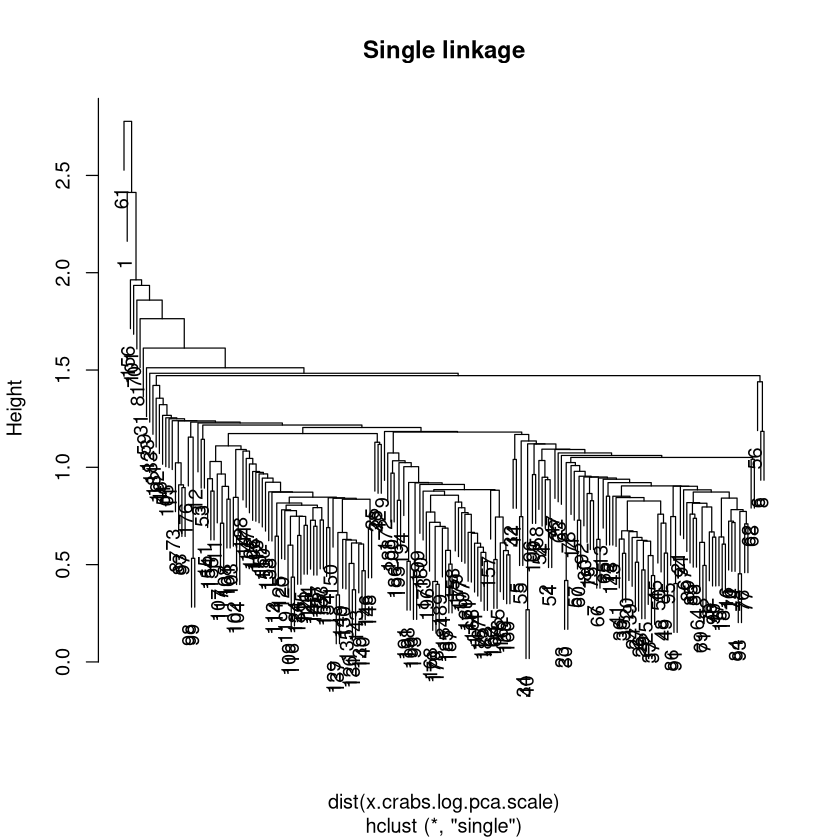

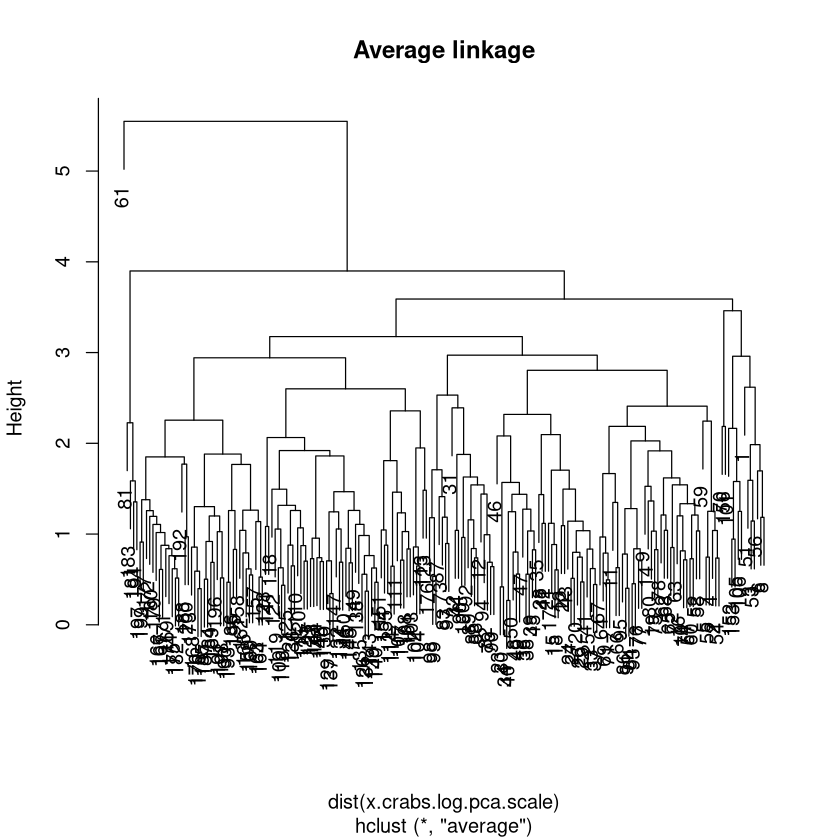

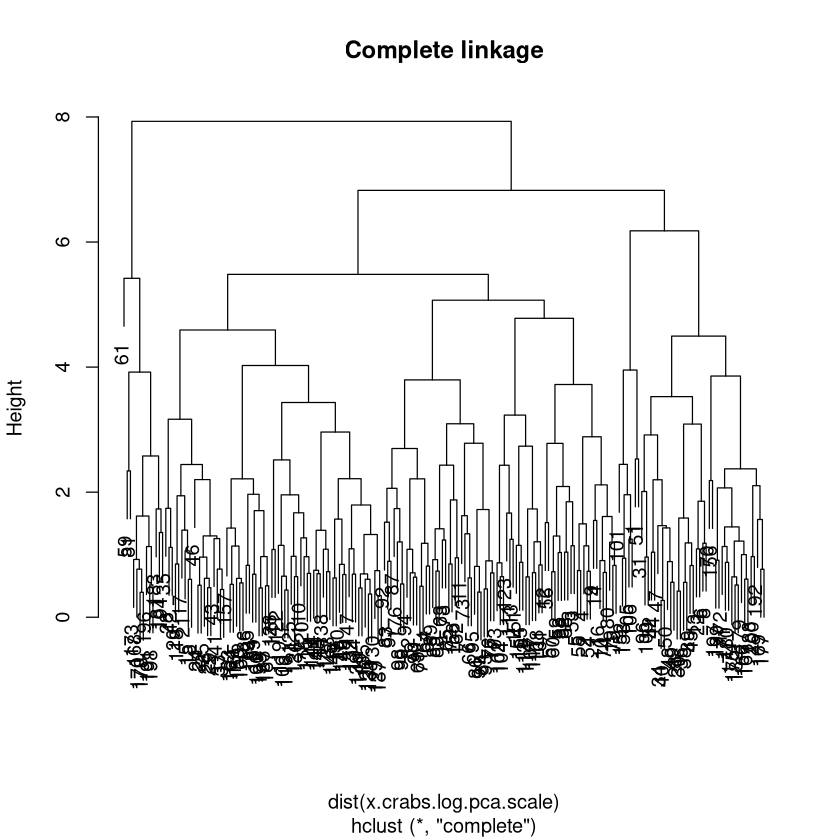

In [10]:
h.single <- hclust(dist(x.crabs.log.pca.scale), method="single")
h.average <- hclust(dist(x.crabs.log.pca.scale), method="average")
h.complete <- hclust(dist(x.crabs.log.pca.scale), method="complete")

plot(h.single, main="Single linkage")
plot(h.average, main="Average linkage")
plot(h.complete, main="Complete linkage")

En los dendogramas se ve que los métodos fueron afectados por outliers, ya que en los tres gráficos en el primer nivel se produce una separación donde la rama izquierda contiene unos pocos datos y todo el resto del conjunto queda en la rama derecha, dónde se distribuyen de una forma muy dispareja para single linkage y de una forma mejor distribuida para average y complete linkage.

¿Obtendría una mejor clusterización si me quedara solo con la rama derecha a partir del tercer o segundo nivel para average y complete? (¿Si es posible?)

In [11]:
c.single <- cutree(h.single, k=2) 
c.average <- cutree(h.average, k=2)
c.complete <- cutree(h.complete, k=2)

cat("\n---- Single linkage -----")
cat("\n-- Species --\n")
compare.clusters(crabs$sp,c.single)
cat("\n-- Sex --\n")
compare.clusters(crabs$sex,c.single)

cat("\n---- Average linkage -----")
cat("\n-- Species --\n")
compare.clusters(crabs$sp,c.average)
cat("\n-- Sex --\n")
compare.clusters(crabs$sex,c.average)

cat("\n---- Complete linkage -----")
cat("\n-- Species --\n")
compare.clusters(crabs$sp,c.complete)
cat("\n-- Sex --\n")
compare.clusters(crabs$sex,c.complete)


---- Single linkage -----
-- Species --
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 50.5 %
         clusters2
clusters1   2   1
        B   1  99
        O   0 100

-- Sex --
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 50.5 %
         clusters2
clusters1   2   1
        F   1  99
        M   0 100

---- Average linkage -----
-- Species --
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 50.5 %
         clusters2
clusters1   2   1
        B   1  99
        O   0 100

-- Sex --
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 50.5 %
         clusters2
clusters1   2   1
        F   1  99
        M   0 100

---- Complete linkage -----
-- Species --
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 53.5 %
         clusters2
clusters1  1  2
        B 97  3

Al cortar los árboles para separar en dos grupos los resultados fueron pésimos. Por lo dicho en el comentario anterior, un cluster queda con unos pocos datos y todos los demás quedan en el otro cluster.

### Apartado b

In [12]:
load("lampone.Rdata")

Por la cantidad de dimensiones (y lo dicho en el enunciado), aplico PCA directamente a los datos y grafico las 8 variables más importantes separando por colores para cada clasificación de la misma forma que en el dataset anterior.

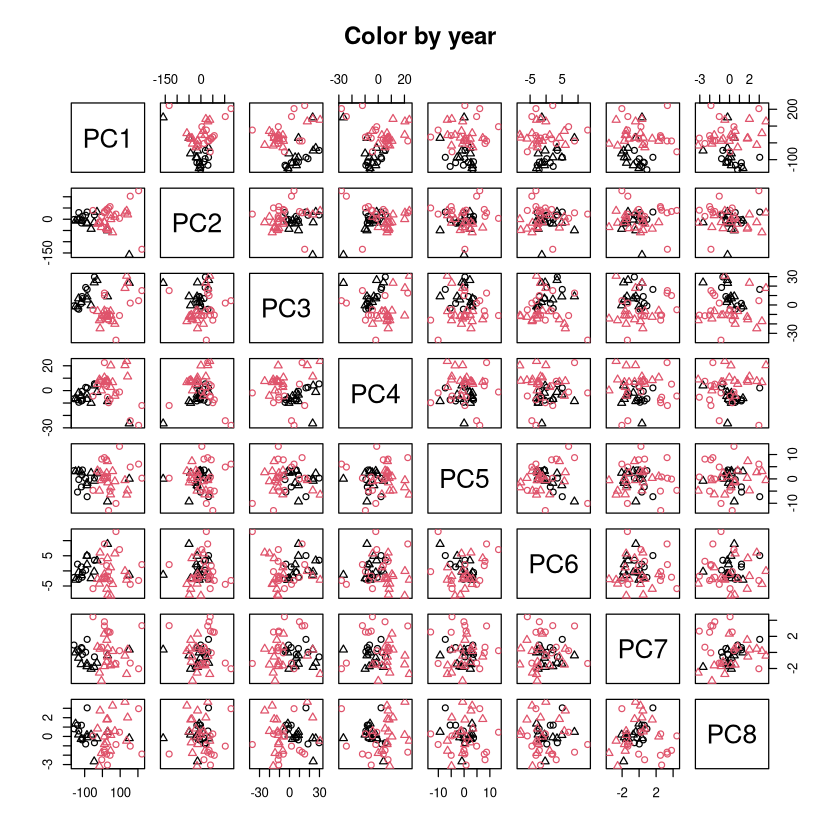

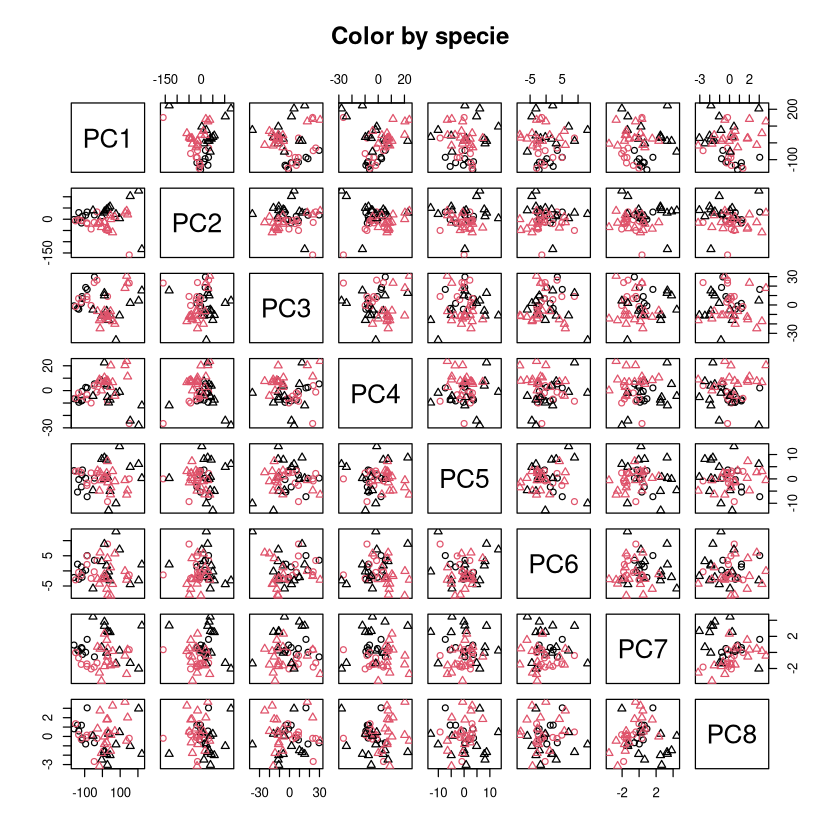

In [13]:
x.lampone <- lampone[,-c(1, 143, 144)] # Saco la columna 144 porque es un factor y me rompe todo
x.lampone.pca <- as.data.frame(prcomp(x.lampone)$x)
plot(x.lampone.pca[,1:8], col=as.numeric(lampone[,1]), pch=as.numeric(lampone[,143]), main="Color by year")
plot(x.lampone.pca[,1:8], col=as.numeric(lampone[,143]), pch=as.numeric(lampone[,1]), main="Color by specie")

En el gráfico separando por año se ve cómo para algunas variables es posible separar claramente en dos grupos mientras que en el gráfico separando por especie hay más overlap entre los datos, esto se debería notar en los resultados al usar kmeans.

In [14]:
cc <- kmeans(x.lampone.pca, cent=2)
cat("\n-- Year --\n")
compare.clusters(lampone[,1], cc$cluster)
cat("\n-- Species --\n")
compare.clusters(lampone[,143], cc$cluster)


-- Year --
Direct agreement: 2 of 2 pairs
Cases in matched pairs: 91.84 %
         clusters2
clusters1  2  1
     2006 17  2
     2007  2 28

-- Species --
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 57.14 %
         clusters2
clusters1  2  1
       2  10 12
       10  9 18


El clustering por año fue muy bueno, con un match del 91.84% mientras que por especie se observa que es una separación más complicada de realizar

In [15]:
x.lampone.pca.scale <- as.data.frame(scale(x.lampone.pca))
cc <- kmeans(x.lampone.pca.scale, cent=2)
cat("\n-- Year --\n")
compare.clusters(lampone[,1], cc$cluster)
cat("\n-- Species --\n")
compare.clusters(lampone[,143], cc$cluster)


-- Year --
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 57.14 %
         clusters2
clusters1  2  1
     2006  5 14
     2007  7 23

-- Species --
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 63.27 %
         clusters2
clusters1  2  1
       2   8 14
       10  4 23


Escalando los datos los resultados empeoran notablemente, pienso que esto se debe a que las variables más importantes tienen valores más grandes comparados a los valores de las variables menos importantes, al escalar todas juntas las distancias se balancean y estas variables menores tienen más peso a la hora de calcular la distancia de los centros a los puntos de sus clusters en cada iteración.

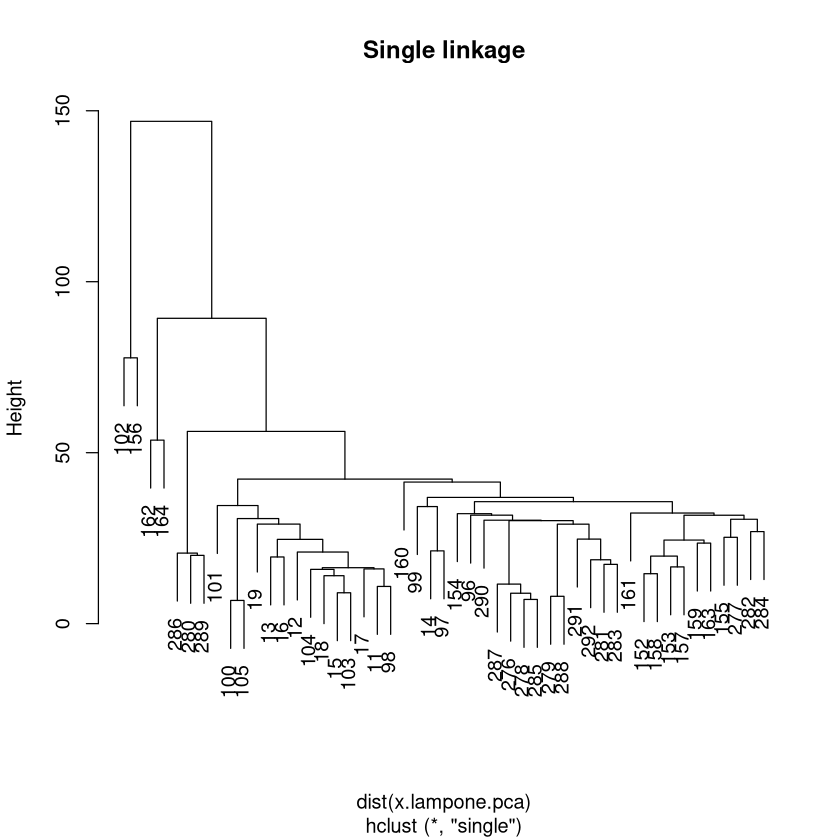

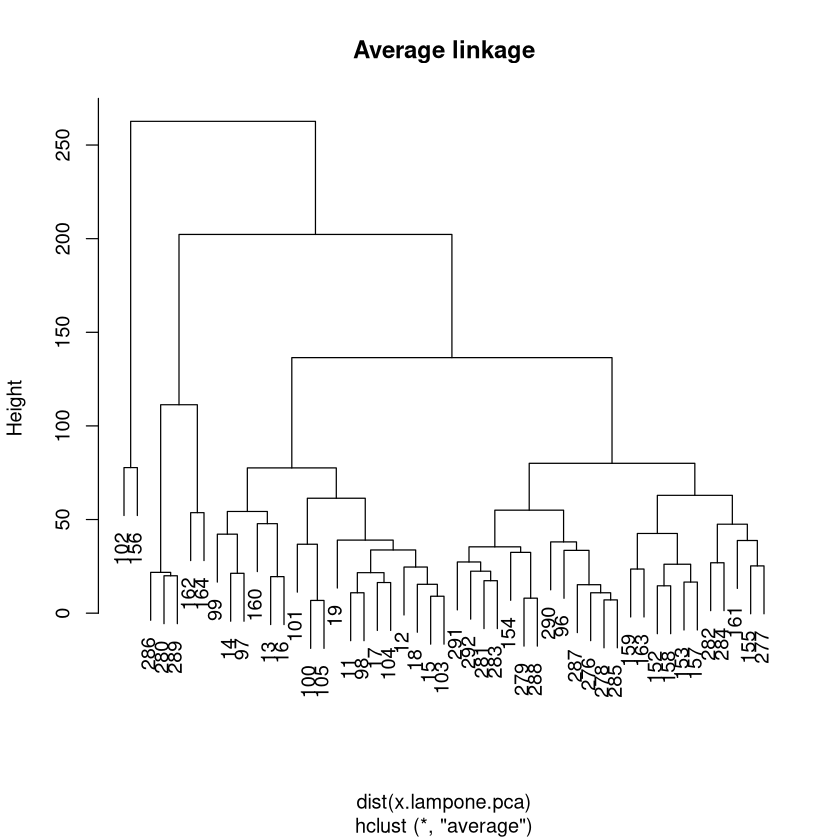

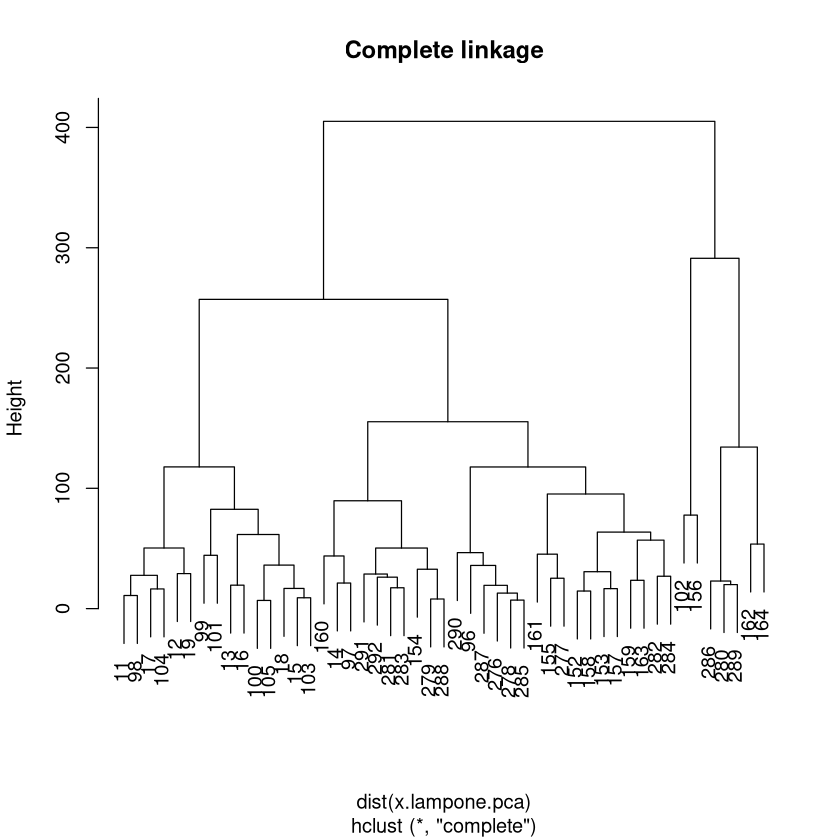

In [16]:
h.single <- hclust(dist(x.lampone.pca), method="single")
h.average <- hclust(dist(x.lampone.pca), method="average")
h.complete <- hclust(dist(x.lampone.pca), method="complete")

plot(h.single, main="Single linkage")
plot(h.average, main="Average linkage")
plot(h.complete, main="Complete linkage")

In [17]:
c.single <- cutree(h.single, k=2) 
c.average <- cutree(h.average, k=2)
c.complete <- cutree(h.complete, k=2)

cat("\n---- Single linkage -----")
cat("\n-- Year --\n")
compare.clusters(lampone[,1],c.single)
cat("\n-- Species --\n")
compare.clusters(lampone[,143],c.single)

cat("\n---- Average linkage -----")
cat("\n-- Year --\n")
compare.clusters(lampone[,1],c.average)
cat("\n-- Species --\n")
compare.clusters(lampone[,143],c.average)

cat("\n---- Complete linkage -----")
cat("\n-- Year --\n")
compare.clusters(lampone[,1],c.complete)
cat("\n-- Species --\n")
compare.clusters(lampone[,143],c.complete)


---- Single linkage -----
-- Year --
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 61.22 %
         clusters2
clusters1  2  1
     2006  1 18
     2007  1 29

-- Species --
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 55.1 %
         clusters2
clusters1  2  1
       2   1 21
       10  1 26

---- Average linkage -----
-- Year --
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 61.22 %
         clusters2
clusters1  2  1
     2006  1 18
     2007  1 29

-- Species --
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 55.1 %
         clusters2
clusters1  2  1
       2   1 21
       10  1 26

---- Complete linkage -----
-- Year --
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 51.02 %
         clusters2
clusters1  2  1
     2006  1 18
     2007  6 24

-- S

Similar a lo que sucedió con el dataset crabs, los métodos de clustering jerárquico no fueron efectivos

Para estos datos, si quiero separar por el año el primer método ya fue muy bueno, si quiero separar por especie habrá que buscar otros métodos ya que con estos los resultados no fueron buenos

--------------------------------------------------------------------------------
## Ejercicio 2

In [18]:
gap.statistic <- function(x, max.k, b.references) {
  # Como el k más chico que busco depende de k + 1 calculo para max.k + 1
  # pero luego devuelvo los primeros max.k (aunque probablemente corte antes de
  # llegar a esto)
  max.k <- max.k + 1
  rows <- nrow(x)
  columns <- ncol(x)

  gaps <- double(max.k)
  s <- double(max.k)

  # Voy a generar los datasets de referencia sobre la PCA de los datos.
  # Calculo los máximos y minimos para cada variable de la PCA para generar
  # con una distribución uniforme sobre esos valores
  x.pca <- prcomp(x)$x
  x.mins <- apply(x.pca, 2, min)
  x.maxs <- apply(x.pca, 2, max)

  # Genero los datasets de referencia, utilizo siempre los mismos b datasets para
  # todos los k para tener resultados mas consistentes
  reference.datasets <- list()
  for (b in 1:b.references) {
    dataset <- c()
    for (i in 1:rows) {
      dataset <- rbind(dataset, runif(columns, min=x.mins, max=x.maxs))
    }
    reference.datasets[[b]] <- dataset
  }

  for (k in 1:max.k) {
    # Calculo la dispersión para este k con los datos originales
    Wk <- kmeans(x, cent=k)$tot.withinss

    # Calculo la dispersión para los datasets de referencia
    Wkb <- double(b.references)
    for (b in 1:b.references) {
      Wkb[b] <- kmeans(reference.datasets[[b]], cent=k)$tot.withinss
    }

    # Un poco de trabalengua estadístico
    l <- (1 / b.references) * sum(log(Wkb))
    sdk <- sqrt((1 / b.references) * sum((log(Wkb) - l)^2))
    s[k] <- sdk * sqrt(1 + (1 / b.references))

    gaps[k] <- (1 / b.references) * sum(log(Wkb) - log(Wk))
  }

  # Ahora a buscar el mínimo k tal que gaps[k] >= gaps[k + 1] - s[k + 1]
  best.k <- 2 # Arranco en 2 o se queda casi siempre en 1
  while (best.k < max.k && 
         gaps[best.k] < gaps[best.k + 1] - s[best.k + 1]) {
    best.k <- best.k + 1
  }

  return(list(best.k = best.k, gaps = gaps[1:max.k - 1]))
}

In [19]:
# Función que calcula el score de estabilidad  de dos soluciones de clustering
# (misma del enunciado)
stability.score <- function(n, ind1, cc1, ind2, cc2) {
  #pongo los clusters de nuevo en longitud n - quedan 0 los puntos fuera del sample
  v1<-v2<-rep(0,n)
  v1[ind1]<-cc1
  v2[ind2]<-cc2
  #creo una matriz m con 1 donde los dos puntos estan en el mismo cluster, -1 en distinto cluster y 0 si alguno no esta, para cada
  # clustering
  a<-sqrt(v1%*%t(v1))
  m1<-a / -a + 2*(a==round(a))
  m1[is.nan(m1)]<-0
  a<-sqrt(v2%*%t(v2))
  m2<-a / -a + 2*(a==round(a))
  m2[is.nan(m2)]<-0
  #calculo el score, los pares de puntos que estan en la misma situacion en los dos clustering dividido el total de pares validos.
  validos<-sum(v1*v2>0)
  sum((m1*m2)[upper.tri(m1)]>0)/(validos*(validos-1)/2)
}

# Recibo los datos que quiero clusterizar, la cantidad maxima de clusters,
# la cantidad de replicas que voy a generar para cada k
# y el porcentaje utilizado para hacer subsampling
stability <- function(x, max.k, replics, sub.percent=0.9) {
  mean.scores = double(max.k)
  rows <- dim(x)[1]

  # Preparo los indices para subsamplear para cada k (datos perturbados)
  subsamples.ind <- c()
  for (rep in 1:replics) {
    subsamples.ind <- rbind(subsamples.ind, sample(rows,sub.percent*rows))
  }

  for (k in 1:max.k) {
    # Hago kmeans para cada subset de datos perturbados
    kmeans <- c()
    for (rep in 1:replics) {
      kmeans <- rbind(kmeans, kmeans(x[subsamples.ind[rep, ]], cent=k,nsta=10)$cluster)
    }

    # Calculo la estabilidad entre cada par de réplicas para luego calcular la media
    scores <- c()
    for (ind1 in 1:(replics - 1)) {
      for (ind2 in (ind1 + 1):replics) {
        scores <- c(scores, stability.score(rows, subsamples.ind[ind1,], kmeans[ind1,], subsamples.ind[ind2,], kmeans[ind2, ]))
      }
    }
    mean.scores[k] <- mean(scores)
  }
  # Le pongo NaN a 1 porque si hay un solo cluster la estabilidad es perfecta
  # y siempre va a ser el máximo, dejo k=1 en el vector también para que
  # scores[best.k] me de el score correspondiente
  mean.scores[1] <- NaN

  return(list(best.k=which.max(mean.scores), scores=mean.scores))
}

### 4 Gausianas

---- Gap ----
Cantidad de veces que recomendó cada k:

[1] 0 2 1 6 0 1 0 0 0 0

K recomendado por gap:  4 

---- Stability ----
K recomendado por stability:  2 


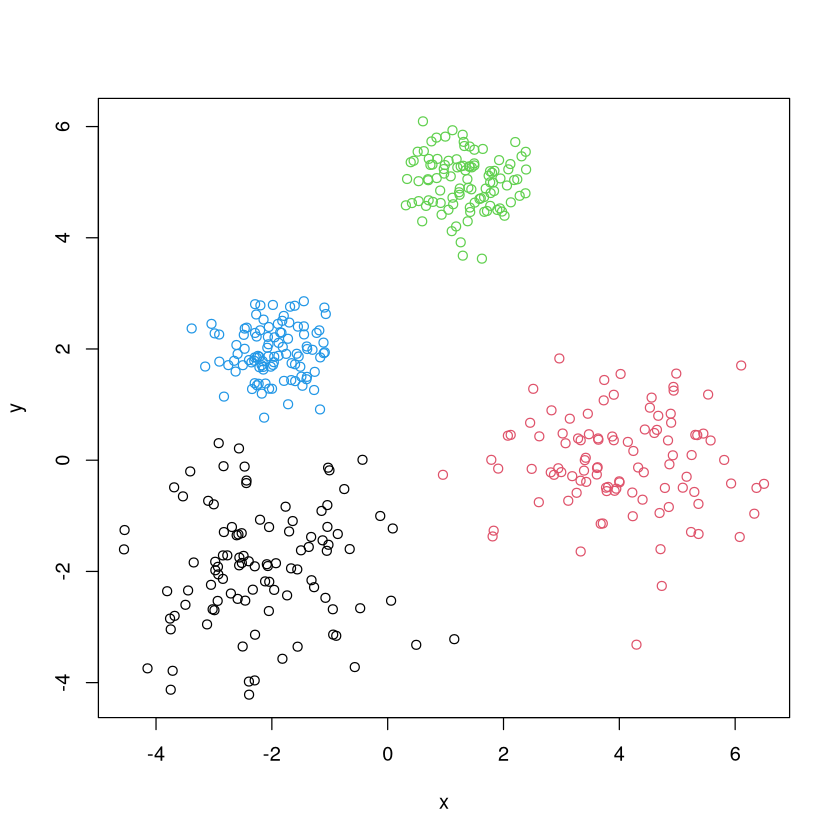

In [21]:
cuatro.gausianas <- function(tot.puntos, gap=2) {
  #cuatro clusters de dist. gaussianas
  x<-rnorm(tot.puntos,mean=-gap)
  y<-rnorm(tot.puntos,mean=-gap)
  gausianas<-cbind(x,y,rep(1,length(x)))
  x<-rnorm(tot.puntos,mean=2*gap)
  y<-rnorm(tot.puntos,mean=0)
  gausianas<-rbind(gausianas,cbind(x,y,rep(2,length(x))))
  x<-rnorm(tot.puntos,mean=0.7*gap,sd=0.5)
  y<-rnorm(tot.puntos,mean=2.5*gap,sd=0.5)
  gausianas<-rbind(gausianas,cbind(x,y,rep(3,length(x))))
  x<-rnorm(tot.puntos,mean=-gap,sd=0.5)
  y<-rnorm(tot.puntos,mean=gap,sd=0.5)
  gausianas<-rbind(gausianas,cbind(x,y,rep(4,length(x))))
}

gausianas <- cuatro.gausianas(100)
x.gausianas <- gausianas[,1:2]
plot(x.gausianas,col=gausianas[,3])
x.gausianas <- prcomp(x.gausianas)$x

# Para minimizar un poco la variación por la aleatoriedad de k-means, corro
# cada 10 veces y cuento cuántas veces sale un k como recomendado
count.gap <- rep(0, 10)
for (i in 1:10) {
  k <- gap.statistic(x.gausianas, 8, 1000)$best.k
  count.gap[k] <- count.gap[k] + 1
}

cat("---- Gap ----\n")
cat("Cantidad de veces que recomendó cada k:")
count.gap
cat("K recomendado por gap: ", which.max(count.gap),"\n")

cat("\n---- Stability ----\n")
cat("K recomendado por stability: ", stability(x.gausianas, 8, 50)$best.k,"\n")

### Iris

---- Gap ----
Cantidad de veces que recomendó cada k:

[1] 0 3 4 3 0 0 0 0 0 0

K recomendado por gap:  3 

---- Stability ----
K recomendado por stability:  2 


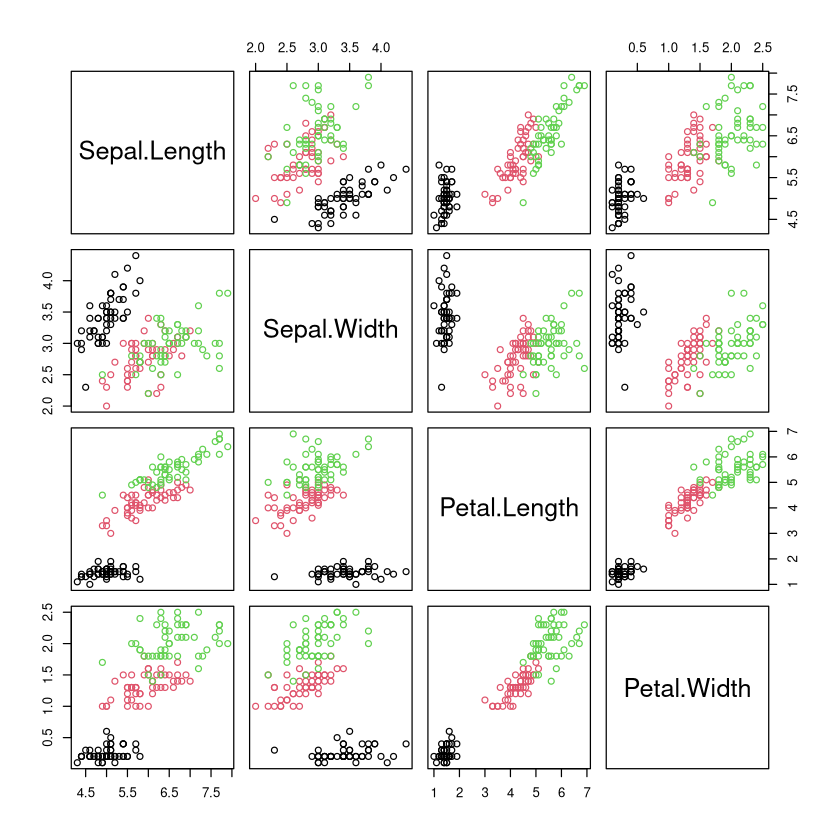

In [22]:
data(iris)
x.iris <- iris[,-5]
plot(x.iris, col=iris[,5])
x.iris <- prcomp(x.iris)$x # Le hago PCA, ayuda bastante a encontrar el k correcto

# Para minimizar un poco la variación por la aleatoriedad de k-means, corro
# cada 10 veces y cuento cuántas veces sale un k como recomendado
count.gap <- rep(0, 10)
for (i in 1:10) {
  k <- gap.statistic(x.iris, 8, 1000)$best.k
  count.gap[k] <- count.gap[k] + 1
}

cat("---- Gap ----\n")
cat("Cantidad de veces que recomendó cada k:")
count.gap
cat("K recomendado por gap: ", which.max(count.gap),"\n")

cat("\n---- Stability ----\n")
cat("K recomendado por stability: ", stability(x.iris, 8, 50)$best.k,"\n")

### Lampone

In [23]:
load("lampone.Rdata")
x.lampone <- prcomp(lampone[,-c(1, 143, 144)])$x # Le hago PCA por la cantidad de variables que tiene

# Para minimizar un poco la variación por la aleatoriedad de k-means, corro
# cada 10 veces y cuento cuántas veces sale un k como recomendado
count.gap <- rep(0, 10)
for (i in 1:10) {
  k <- gap.statistic(x.lampone, 8, 1000)$best.k
  count.gap[k] <- count.gap[k] + 1
}

cat("---- Gap ----\n")
cat("Cantidad de veces que recomendó cada k:")
count.gap
cat("K recomendado por gap: ", which.max(count.gap),"\n")

cat("\n---- Stability ----\n")
cat("K recomendado por stability: ", stability(x.lampone, 8, 50)$best.k,"\n")

---- Gap ----
Cantidad de veces que recomendó cada k:

[1]  0 10  0  0  0  0  0  0  0  0

K recomendado por gap:  2 

---- Stability ----
K recomendado por stability:  3 


Para todos los datasets el método de gap statistic encontró correctamente
la cantidad de clusters mientras que en todos stability le erró, no tengo comentarios interesantes para realizar sobre estos resultados. (Solamente espero haber programado bien el método de stability)

--------------------------------------------------------------------------------
## Ejercicio 3

Para este ejercicio encontré un dataset que me pareció interesante que trata sobre vinos, este dataset es el resultado de un análisis químico donde hay 13 variables con mediciones de diferentes componentes de 3 tipos de vino. **[Fuente del dataset](https://archive.ics.uci.edu/ml/datasets/wine)**

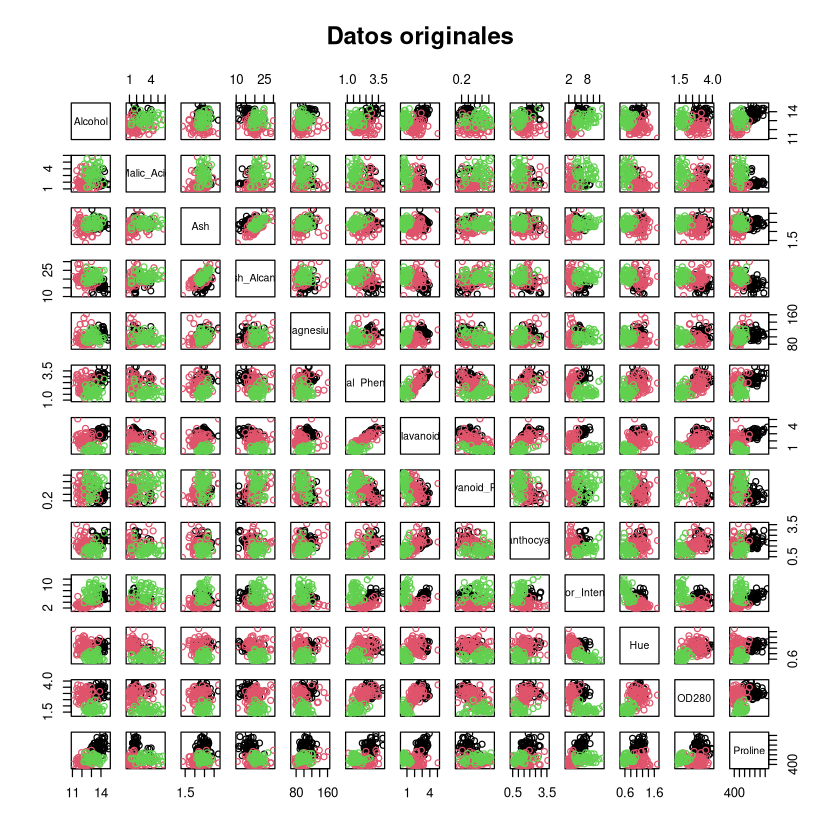

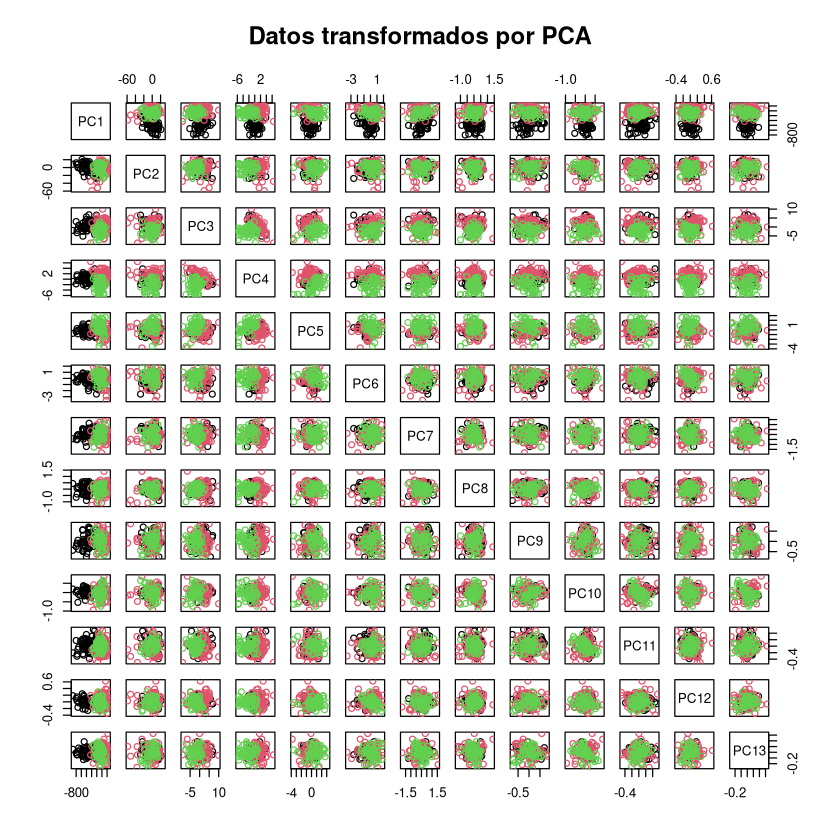

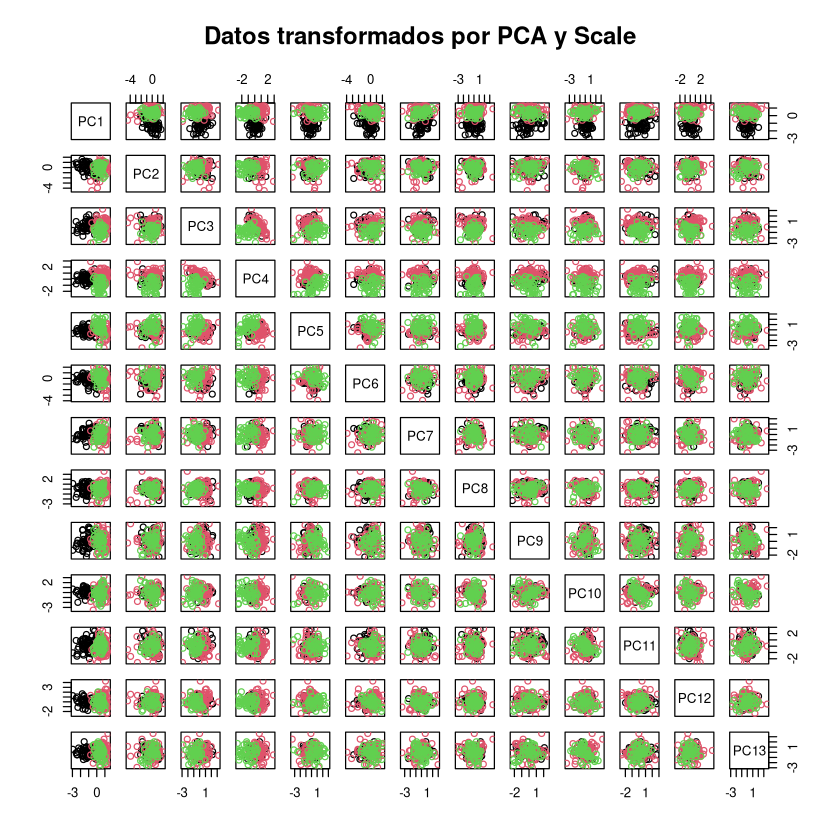

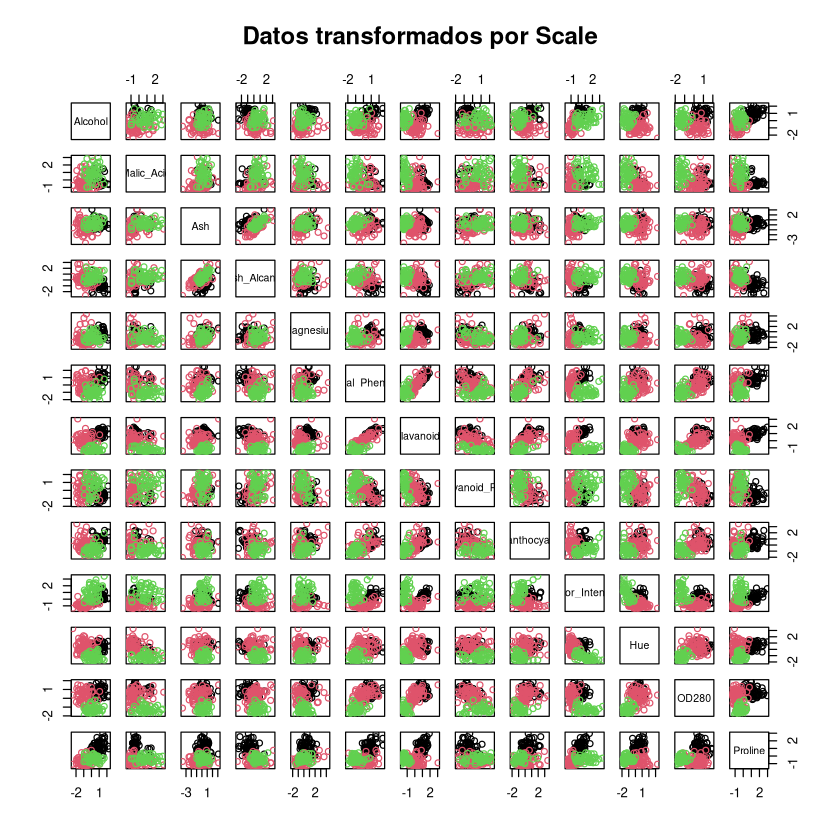

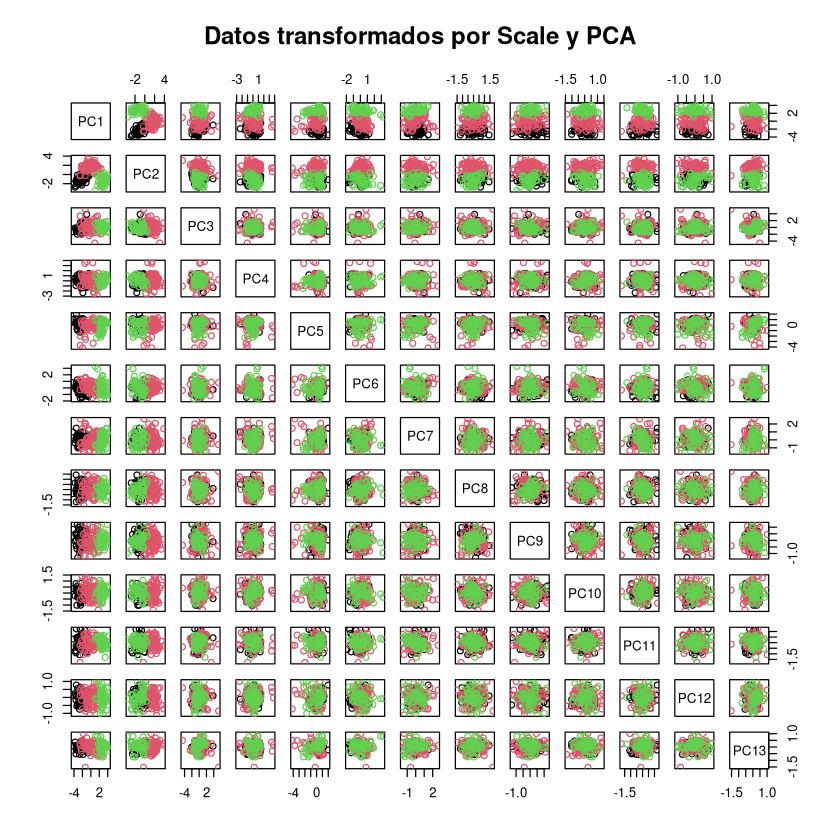

In [59]:
# Leo los datos y los grafico
wine <- read.csv("wine.csv") # Por suerte los datos ya vienen bastante limpios y no hay que hacerles nada
x.wine <- wine[,-1]
plot(x.wine, col=wine[,1], main="Datos originales")

# Pruebo diferentes métodos de transformar los datos
x.wine.pca <- prcomp(x.wine)$x
plot(as.data.frame(x.wine.pca), col=wine[,1],main="Datos transformados por PCA")

x.wine.pca.scale <- scale(prcomp(x.wine)$x)
plot(as.data.frame(x.wine.pca.scale), col=wine[,1],main="Datos transformados por PCA y Scale")

x.wine.scale <- scale(x.wine)
plot(as.data.frame(x.wine.scale), col=wine[,1],main="Datos transformados por Scale")

x.wine.scale.pca <- prcomp(x.wine.scale)$x
plot(as.data.frame(x.wine.scale.pca), col=wine[,1],main="Datos transformados por Scale y PCA")

# si no hago as matrix los métodos se me rompen
x.wine <- as.matrix(x.wine)

En los gráficos se puede ver que hay overlap entre los 3 clusters incluso aplicando PCA, pero si aplico scale a los datos estos grupos se separan y luego al aplicar PCA sobre los datos escalados este overlap se reduce. Igualmente voy a probar con todos los datos para ver cómo esto afecta los resultados.

In [60]:
cat("---------- Datos originales -----\n")
count.gap <- rep(0, 10)
for (i in 1:10) {
  k <- gap.statistic(x.wine, 8, 1000)$best.k
  count.gap[k] <- count.gap[k] + 1
}

cat("---- Gap ----\n")
cat("Cantidad de veces que recomendó cada k:")
count.gap
cat("K recomendado por gap: ", which.max(count.gap),"\n")

cat("\n---- Stability ----\n")
cat("K recomendado por stability: ", stability(x.wine, 8, 50)$best.k,"\n")

cat("\n---------- PCA -----\n")
count.gap <- rep(0, 10)
for (i in 1:10) {
  k <- gap.statistic(x.wine.pca, 8, 1000)$best.k
  count.gap[k] <- count.gap[k] + 1
}

cat("---- Gap ----\n")
cat("Cantidad de veces que recomendó cada k:")
count.gap
cat("K recomendado por gap: ", which.max(count.gap),"\n")

cat("\n---- Stability ----\n")
cat("K recomendado por stability: ", stability(x.wine.pca, 8, 50)$best.k,"\n")

cat("\n---------- PCA y Scale -----\n")
count.gap <- rep(0, 10)
for (i in 1:10) {
  k <- gap.statistic(x.wine.pca.scale, 8, 1000)$best.k
  count.gap[k] <- count.gap[k] + 1
}

cat("---- Gap ----\n")
cat("Cantidad de veces que recomendó cada k:")
count.gap
cat("K recomendado por gap: ", which.max(count.gap),"\n")

cat("\n---- Stability ----\n")
cat("K recomendado por stability: ", stability(x.wine.pca.scale, 8, 50)$best.k,"\n")

cat("\n---------- Scale -----\n")
count.gap <- rep(0, 10)
for (i in 1:10) {
  k <- gap.statistic(x.wine.scale, 8, 1000)$best.k
  count.gap[k] <- count.gap[k] + 1
}

cat("---- Gap ----\n")
cat("Cantidad de veces que recomendó cada k:")
count.gap
cat("K recomendado por gap: ", which.max(count.gap),"\n")

cat("\n---- Stability ----\n")
cat("K recomendado por stability: ", stability(x.wine.scale, 8, 50)$best.k,"\n")

cat("\n---------- Scale y PCA -----\n")
count.gap <- rep(0, 10)
for (i in 1:10) {
  k <- gap.statistic(x.wine.scale.pca, 8, 1000)$best.k
  count.gap[k] <- count.gap[k] + 1
}

cat("---- Gap ----\n")
cat("Cantidad de veces que recomendó cada k:")
count.gap
cat("K recomendado por gap: ", which.max(count.gap),"\n")

cat("\n---- Stability ----\n")
cat("K recomendado por stability: ", stability(x.wine.scale.pca, 8, 50)$best.k,"\n")

---------- Datos originales -----
---- Gap ----
Cantidad de veces que recomendó cada k:

[1]  0 10  0  0  0  0  0  0  0  0

K recomendado por gap:  2 

---- Stability ----
K recomendado por stability:  2 

---------- PCA -----
---- Gap ----
Cantidad de veces que recomendó cada k:

[1]  0 10  0  0  0  0  0  0  0  0

K recomendado por gap:  2 

---- Stability ----
K recomendado por stability:  3 

---------- PCA y Scale -----


Warning message:
“did not converge in 10 iterations”


---- Gap ----
Cantidad de veces que recomendó cada k:

[1]  0 10  0  0  0  0  0  0  0  0

K recomendado por gap:  2 

---- Stability ----
K recomendado por stability:  3 

---------- Scale -----


Warning message:
“did not converge in 10 iterations”


---- Gap ----
Cantidad de veces que recomendó cada k:

[1]  0  0 10  0  0  0  0  0  0  0

K recomendado por gap:  3 

---- Stability ----
K recomendado por stability:  2 

---------- Scale y PCA -----
---- Gap ----
Cantidad de veces que recomendó cada k:

[1]  0  0 10  0  0  0  0  0  0  0

K recomendado por gap:  3 

---- Stability ----
K recomendado por stability:  2 


Los resultados son variados, en ninguno de los conjuntos de datos ambos métodos recomendaron 3 clusters, no sabría explicar por qué.

In [72]:
cat("---- Datos originales -----\n")
cc <- kmeans(x.wine, cent=3)
compare.clusters(wine[,1], cc$cluster)

cat("\n---- PCA -----\n")
cc <- kmeans(x.wine.pca, cent=3)
compare.clusters(wine[,1], cc$cluster)

cat("\n---- PCA y Scale -----\n")
cc <- kmeans(x.wine.pca.scale, cent=3)
compare.clusters(wine[,1], cc$cluster)

cat("\n---- Scale -----\n")
cc <- kmeans(x.wine.scale, cent=3)
compare.clusters(wine[,1], cc$cluster)

cat("\n---- Scale y PCA -----\n")
cc <- kmeans(x.wine.scale.pca, cent=3)
compare.clusters(wine[,1], cc$cluster)

---- Datos originales -----
Direct agreement: 2 of 3 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 70.22 %
         clusters2
clusters1  3  1  2
        1 46  0 13
        2  1 50 20
        3  0 19 29

---- PCA -----
Direct agreement: 2 of 3 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 70.22 %
         clusters2
clusters1  1  3  2
        1 46  0 13
        2  1 50 20
        3  0 19 29

---- PCA y Scale -----
Direct agreement: 1 of 3 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 56.18 %
         clusters2
clusters1  3  1  2
        1 38 12  9
        2 19 31 21
        3 14  3 31

---- Scale -----
Direct agreement: 3 of 3 pairs
Cases in matched pairs: 96.63 %
         clusters2
clusters1  1  2  3
        1 59  0  0
        2  3 65  3
        3  0  0 48

---- Scale y PCA -----
Direct agreement: 3 of 3 pairs
Cases in matched pairs: 96.63 %
         clusters2
clusters1  2  1  3
        1 59  0  0
        2  3 65  3

Los resultados son interesantes, el porcentaje de match luego de aplicar k-means sobre los datos originales es bueno y empeora considerablemente luego de transformar los datos con pca y después scale.

Los resultados luego de aplicar scale son muy buenos, el resultado obtenido al aplicarle pca también es exactamente igual a pesar de que en el gráfico las diferencias entre los grupos parecían más claras, esto me sorprendió un poco.